In [1]:
import warnings
import os
import cv2
import random
import keras
import numpy as np
import pandas as pd
import albumentations as A
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)


In [19]:
levels = ['Normal', 'COVID']
path = "COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    level += '/images'
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal/images': 'Negative', 'COVID/images': 'Positive'})
samples = 13808

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-1.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
1,Normal/images/Normal-10.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
2,Normal/images/Normal-100.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
3,Normal/images/Normal-1000.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
4,Normal/images/Normal-10000.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...


In [20]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 13808


In [21]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

In [22]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

,image_file,corona_result,path,image
0,Normal/images/Normal-1.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Normal/images/Normal-10.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[9, 9, 9, 8, 8, 7, 6, 4, 3, 2, 1, 1, 1, 0, 0,..."
2,Normal/images/Normal-100.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[0, 0, 0, 0, 12, 57, 75, 95, 111, 117, 119, 1..."
3,Normal/images/Normal-1000.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[0, 6, 23, 51, 66, 69, 71, 67, 97, 96, 101, 1..."
4,Normal/images/Normal-10000.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[136, 118, 106, 100, 96, 93, 91, 88, 87, 87, ..."


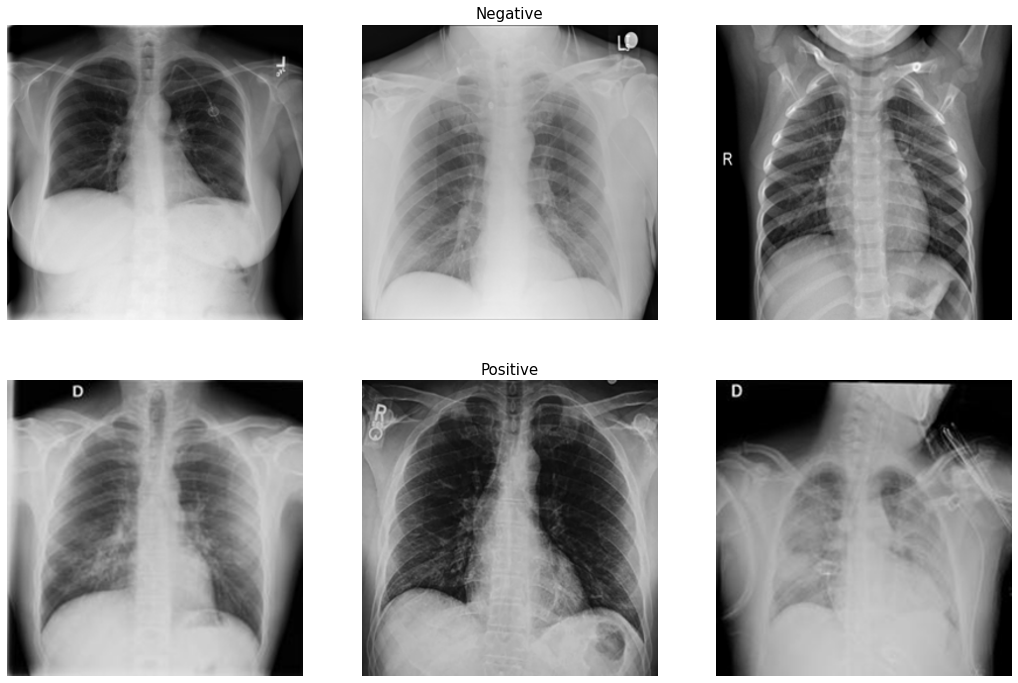

In [23]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

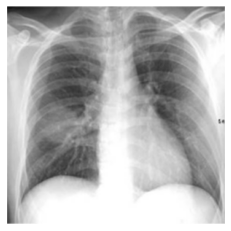

In [25]:
plt.figure()
image = cv2.imread("COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png")
plt.imshow(image)
plt.axis('off')
plt.show() 


In [26]:

print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 5


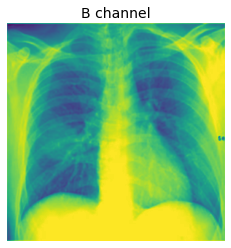

In [27]:
plt.title('B channel', fontsize = 14)
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

In [31]:
all_covid = []
all_normal = []

all_normal.extend(glob(os.path.join(path, "Normal/images/*.png")))
all_covid.extend(glob(os.path.join(path, "COVID/images/*.png")))

random.shuffle(all_normal)
random.shuffle(all_covid)

images = all_normal[:50] + all_covid[:50]

In [33]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

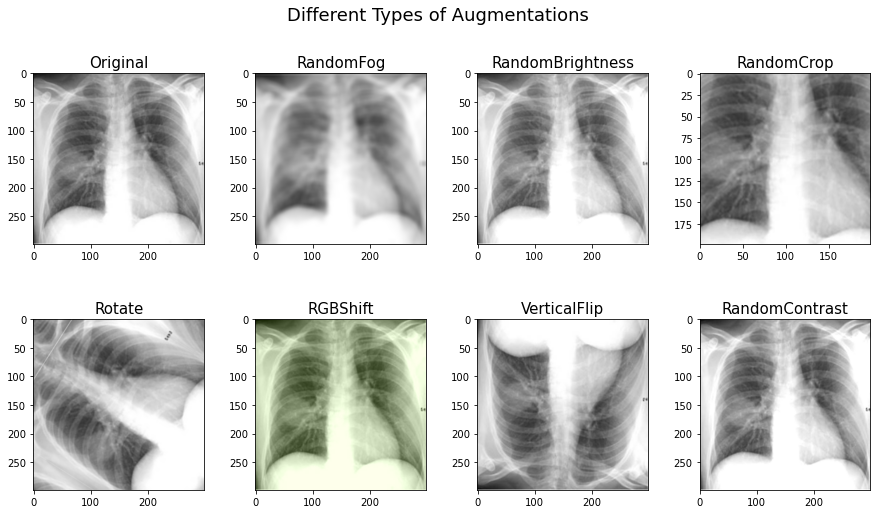

In [34]:
chosen_image = cv2.imread("COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png")

albumentation_list = [A.RandomFog(p = 1), A.RandomBrightness(p = 1),
                      A.RandomCrop(p = 1,height = 199, width = 199), A.Rotate(p = 1, limit = 90),
                      A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomContrast(limit = 0.5, p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

In [35]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

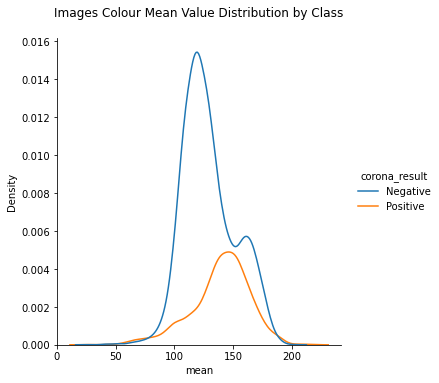

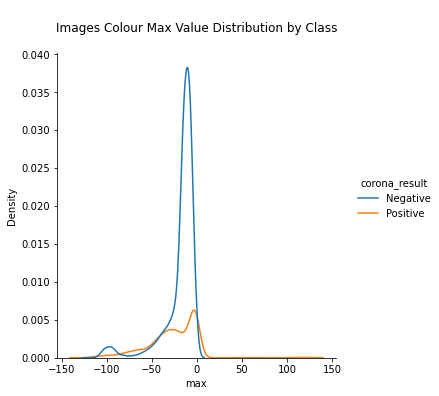

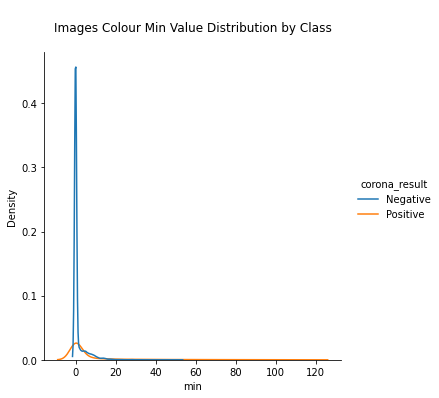

In [36]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'corona_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

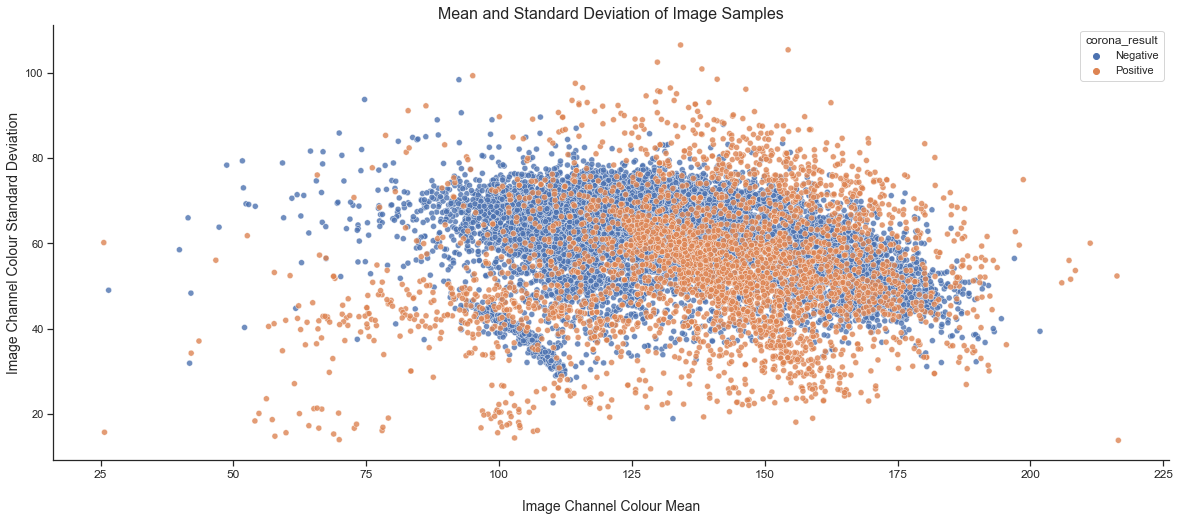

In [37]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

<Figure size 720x576 with 0 Axes>

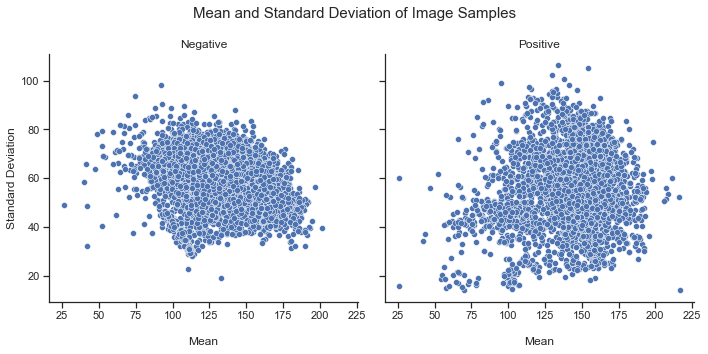

In [38]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "corona_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

In [ ]:
def getImage(path):
    return OffsetImage(cv2.imread(path),zoom = 0.1)

DF_sample = imageEDA.sample(frac=0.1, replace=False, random_state=1)
paths = DF_sample['path']

fig, ax = plt.subplots(figsize=(20,8))
ab = sns.scatterplot(data=DF_sample, x="mean", y='stedev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples - 10% of Data', fontsize = 16,weight = 'bold');

for x0, y0, path in zip(DF_sample['mean'], DF_sample['stedev'],paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [39]:
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [40]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


In [41]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        3

In [42]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 25s 212ms/step - loss: 0.6309 - accuracy: 0.7314 - val_loss: 0.5514 - val_accuracy: 0.7638
Epoch 2/50
39/39 [==============================] - 5s 136ms/step - loss: 0.5466 - accuracy: 0.7330 - val_loss: 0.4827 - val_accuracy: 0.7638
Epoch 3/50
39/39 [==============================] - 5s 137ms/step - loss: 0.5250 - accuracy: 0.7330 - val_loss: 0.4747 - val_accuracy: 0.7638
Epoch 4/50
39/39 [==============================] - 35s 918ms/step - loss: 0.5061 - accuracy: 0.7330 - val_loss: 0.4265 - val_accuracy: 0.7638
Epoch 5/50
39/39 [==============================] - 26s 590ms/step - loss: 0.4827 - accuracy: 0.7330 - val_loss: 0.3926 - val_accuracy: 0.7638
Epoch 6/50
39/39 [==============================] - 21s 439ms/step - loss: 0.4511 - accuracy: 0.7330 - val_loss: 0.3495 - val_accuracy: 0.7638
Epoch 7/50
39/39 [==============================] - 9s 241ms/step - loss: 0.4371 - accuracy: 0.7330 - val_loss: 0.3418 - val_accuracy: 0.7638
Ep

In [43]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

In [44]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7287
           1       0.94      0.95      0.94      2654

    accuracy                           0.97      9941
   macro avg       0.96      0.96      0.96      9941
weighted avg       0.97      0.97      0.97      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.9514
Specificity on Train Data:  0.9768
Accuracy on Train Data:  0.97
Precision on Train Data:  0.9373
F1 Score on Train Data:  0.9443
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       844
           1       0.90      0.89      0.90       261

    accuracy                  

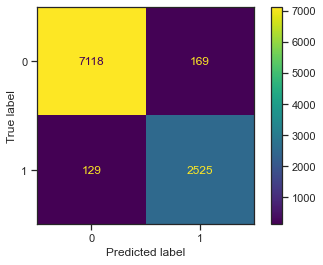

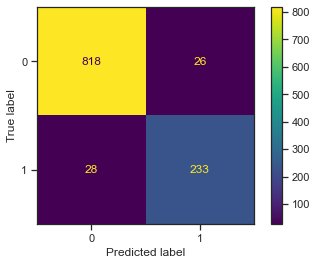

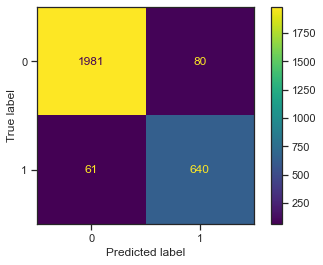

In [45]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

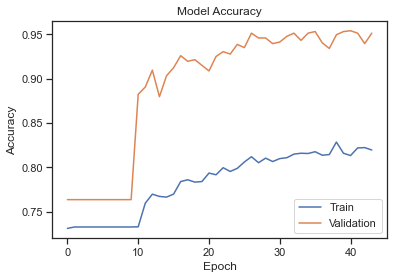

In [46]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

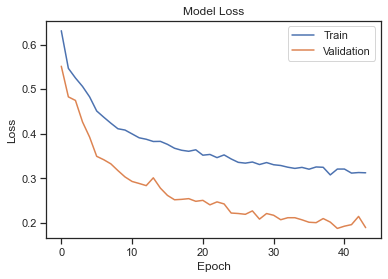

In [47]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

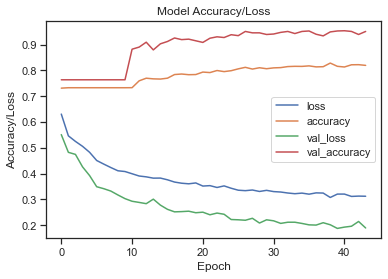

In [48]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [51]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

# Reading 2 Covid & 2 Normal Images for Grad-Cam Analysis

img_path = ["COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png",
            "COVID-19_Radiography_Dataset/COVID/images/COVID-101.png",
            "COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png",
           "COVID-19_Radiography_Dataset/Normal/images/Normal-10002.png"]

In [52]:
# To Get Image into numpy array

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [53]:
# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in img_path:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

91897856/91884032 [==============================] - 3s 0us/step


In [54]:
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(img_path)):
    save_and_display_gradcam(img_path[i], covid_noncovid_heatmap[i])

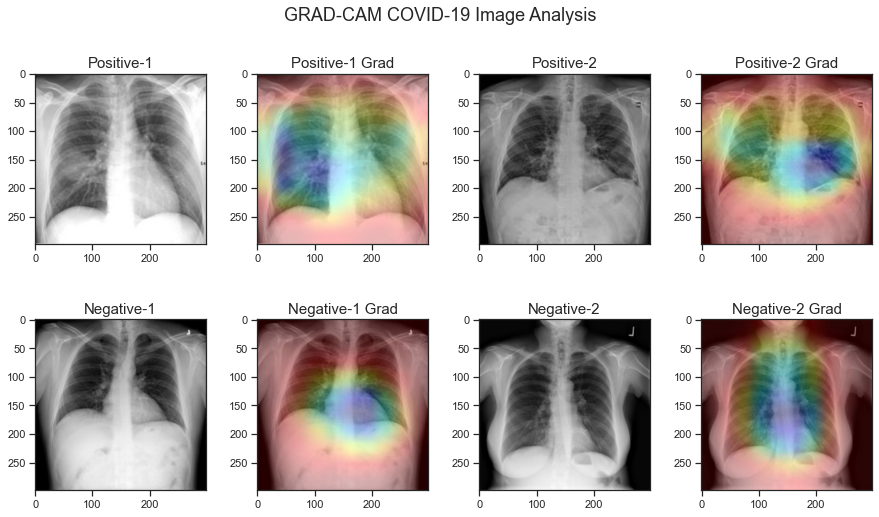

In [55]:
titles_list = ["Positive-1",'Positive-1 Grad','Positive-2','Positive-2 Grad','Negative-1','Negative-1 Grad','Negative-2','Negative-2 Grad']

plot_multiple_img(imag, titles_list, ncols = 4, main_title = "GRAD-CAM COVID-19 Image Analysis")

In [56]:
# Checking predictions for the above sample images

for i in img_path:
    z_img = cv2.imread(i)
    z_img = cv2.resize(z_img, (70, 70)) / 255.0
    z_img = z_img.reshape(1, z_img.shape[0], z_img.shape[1], z_img.shape[2])
    
    z = cnn_model.predict(z_img)
    z = np.argmax(z, axis = 1)
    print("Image", img_path.index(i) + 1, ":", z)

Image 1 : [0]
Image 2 : [1]
Image 3 : [0]
Image 4 : [0]


In [57]:
cnn_model.save('cnn_model.h5')